In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

import itertools

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

Like in IIIa I load and rescale the images and convert them to circuits.
Again I need to scale down the images.  
Pracitcally this could e.g. be done with a calssical cnn.

In [2]:
data = np.load('electron-photon.npz', allow_pickle=True)
IMAGE_SIZE = 4

x_train_scale = tf.image.resize(data['x_train'][...,np.newaxis], (IMAGE_SIZE,IMAGE_SIZE), method='lanczos5').numpy()
x_test_scale = tf.image.resize(data['x_test'][...,np.newaxis], (IMAGE_SIZE,IMAGE_SIZE), method='lanczos5').numpy()

In [3]:
x_train = np.array(x_train_scale > 0, dtype=np.float32)
y_train = data['y_train']
x_test = np.array(x_test_scale > 0, dtype=np.float32)
y_test = data['y_test']

In [4]:
def img_to_circuit(image):
    flat_data = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(IMAGE_SIZE, IMAGE_SIZE)
    c = cirq.Circuit()
    for idx, val in enumerate(flat_data):
        if val:
            c.append(cirq.X(qubits[idx]))
    return c


x_train_circ = [img_to_circuit(x) for x in x_train]
x_test_circ = [img_to_circuit(x) for x in x_test]

In [5]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

The QNN architecture used is taken from 1802.06002 as also described in the tensorflow documentation https://www.tensorflow.org/quantum/tutorials/mnist.
I implement it silimar to task IIIa except the readout qbit is not an input qbit of the image.  
  
A singe layer applies a given 2 bit gate on all qubits with the readout qbit which I denoted as result.
I take the power of respektive gate and then use the pauli gate which should be equivalent to rotations Rx used in task IIIa up to a phase factor.

In [6]:
def layer(qs, result, gate, params):
    circ = cirq.Circuit()
    for i in range(0,len(qs)):     
        circ += gate(qs[i], result)**params[i]
    return circ

Create the qbits

In [7]:
num_qubits = IMAGE_SIZE*IMAGE_SIZE
qubits = [cirq.GridQubit(i, j) for i, j in itertools.product(range(IMAGE_SIZE), range(IMAGE_SIZE))]
print(len(qubits))

16


We have one parameter per qubit per layer. 

In [8]:
layers = 2

num_params = num_qubits * layers
parameters = sympy.symbols("q0:%d"%num_params)
print(len(parameters))

32


Now build the circuit

In [9]:
def build_circuit(qs, params):
    c = cirq.Circuit()
    result = cirq.GridQubit(-1, -1)
    c += cirq.X(result)
    c += cirq.H(result)
    c += layer(qs, result, cirq.XX, params[:len(qs)])
    # could e.g. add another layer
    #c += layer(qs, result, cirq.YY, params[len(qs):2*len(qs)])
    c += layer(qs, result, cirq.ZZ, params[len(qs):2*len(qs)])
    c += cirq.H(result)
    return c, cirq.Z(result)

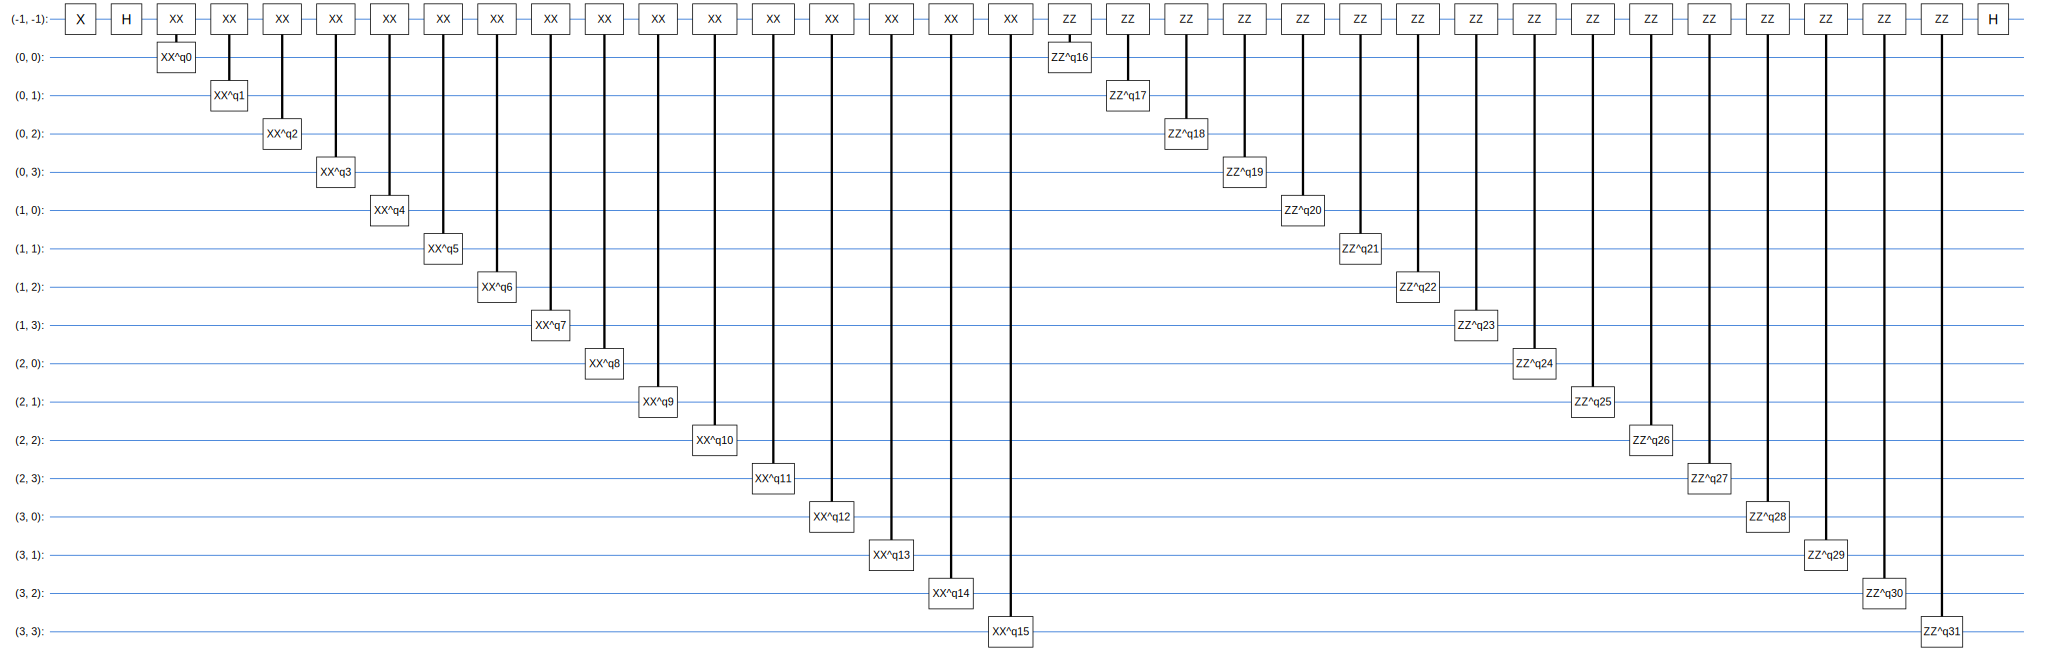

In [10]:
model_circuit, model_readout = build_circuit(qubits, parameters)
SVGCircuit(model_circuit)

I use early stoppen with a patience of 15 on the training loss as validation loss will be quite meaningless on such a small dataset

In [11]:
# Build the Keras model.
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(model_circuit, model_readout),
])

es = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0025, patience=10)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

I use binary crossentropy as loss and adam as optimizer

In [12]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy()])

The model summary again shows the number of parameters

In [13]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 1)                 32        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
EPOCHS = 150
BATCH_SIZE = 16

In [15]:
qnn_history = model.fit(
      x_train_tfcirc, y_train,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test), 
      callbacks=[es])

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/150
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing 

We can see the training loss decresing, indicating that the model is fitting the data.   
Proper training needs to be performed on images with a higher resolution, which will however be lot more expensive resource wise.  
Therefore a hybrid structure with a classical network that reduces the dimensionality followed by a qnn could be practical for real world data

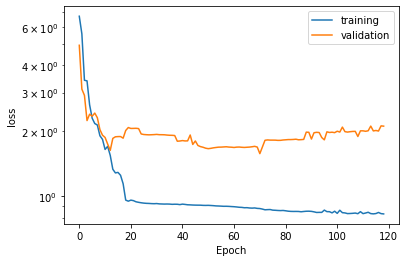

In [17]:
plt.plot(qnn_history.history['loss'], label="training")
plt.plot(qnn_history.history['val_loss'], label="validation")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.yscale('log')
plt.legend()

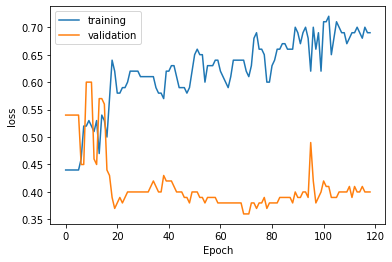

In [18]:
plt.plot(qnn_history.history['binary_accuracy'], label="training")
plt.plot(qnn_history.history['val_binary_accuracy'], label="validation")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()